### Working with Real Data

在本章中，我们从StatLib存储库中选择了California Housing Price数据集（参见下图）。 该数据集基于1990年加利福尼亚人口普查的数据。 这不是最近的（你当时仍然可以在湾区买到一套漂亮的房子），但它有许多学习的特质，所以我们假装它是最近的数据。 我们还添加了一个分类属性，出于教学目的我们删除了一些特征。
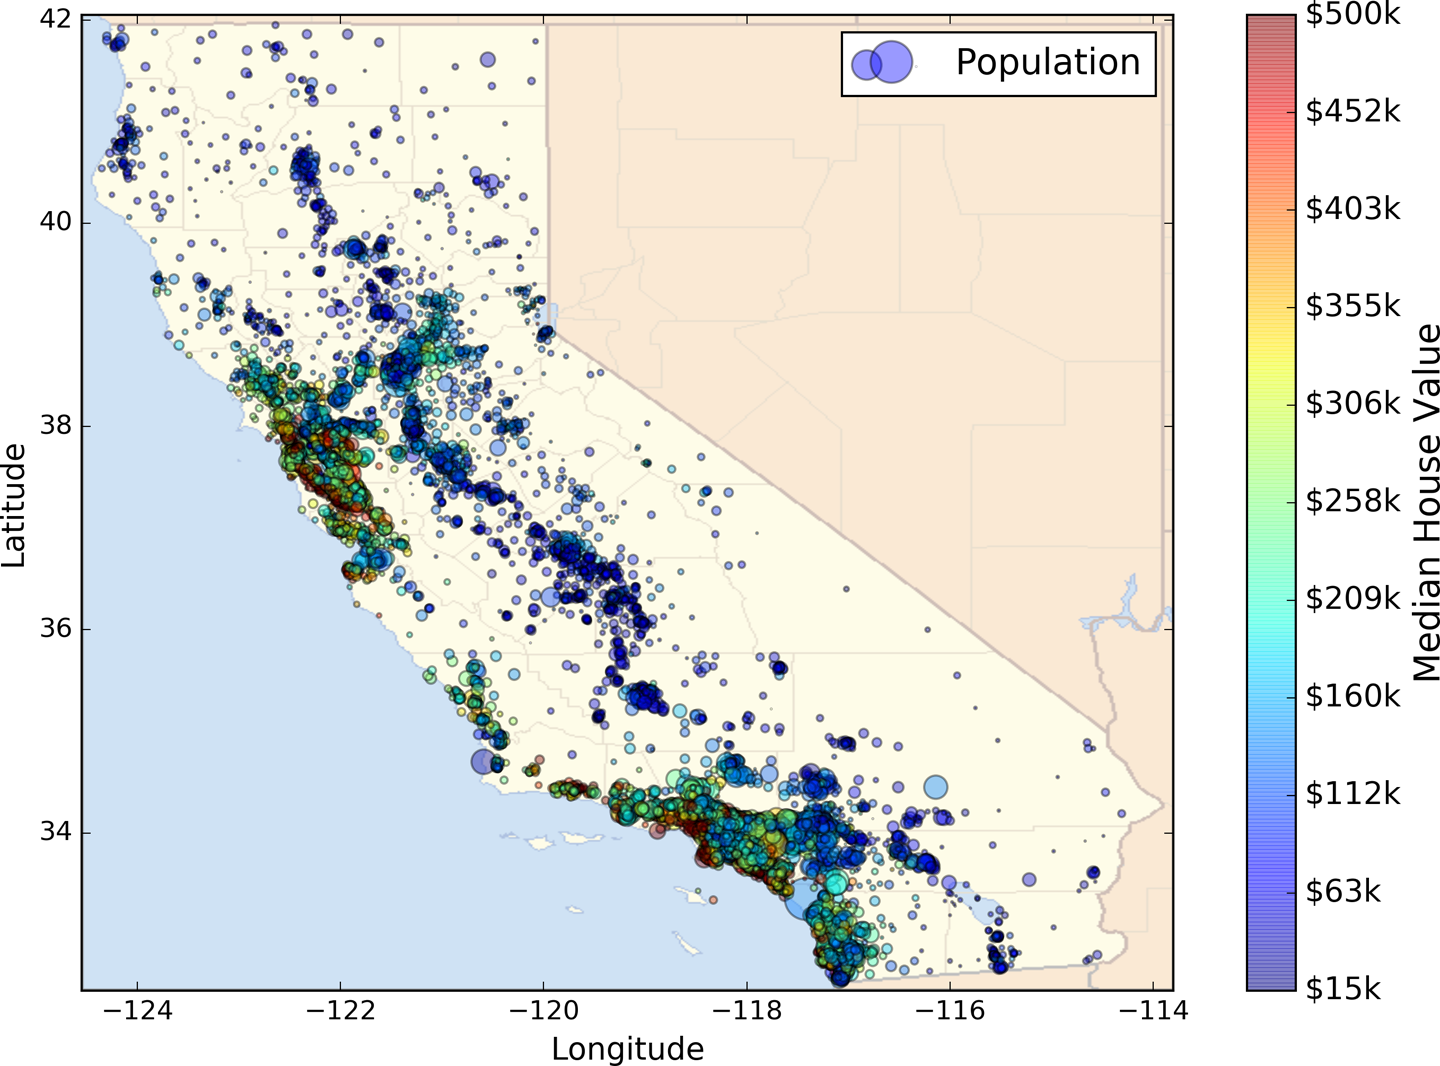

作为一个训练有素的数据科学家，在拿到一个问题时，要做的第一件事就是制作出**机器学习项目清单**。 这个笔记给出了一个可供参考的机器学习项目清单，它应该适用于大多数机器学习项目，但要确保适应您的需求。详细清单见:[Machine Learning Project Checklist](https://www.jianshu.com/p/d9b1a45e2ebd)

此清单可以指导您完成大多数机器学习项目。 有八个主要步骤：
1. 问题框架化，视野宏观化
2. 获取数据
3. 探索数据以获得 深层次见解
4. 准备数据以更好地将基础数据模式提供给机器学习算法
5. 探索不同的模型并列出最优模型
6. 微调模型并将它们组合成一个很好的解决方案
7. 展示您的解决方案
8. 运行，监控和维护您的系统 

实际操作中您可以随意调整此清单以满足您的具体需求

## 0.Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [35]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
# 让笔记全程输入稳定
np.random.seed(42)

# To plot pretty figures
# 导入绘图工具
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
# 设定图片保存路径，这里写了一个函数，后面直接调用即可
PROJECT_ROOT_DIR = "F:\ML\Machine learning\Hands-on machine learning with scikit-learn and tensorflow"
CHAPTER_ID = "02_End_to_End_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
# 忽略无用警告
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 2. Get the data-获取数据

In a real project you would save this code in a **Python file**, but for now you can just write it in your Jupyter notebook.

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"# 这个是保存在jupyter notebook 上了
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

#### 2.1 检查数据的大小和类型（时间序列，样本，地理位置等）

In [4]:
import pandas as pd

# This function returns a Pandas DataFrame object containing all the data.
# 这个函数返回一个包含所有数据的pandas 数据结构
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


When you looked at the top five rows, you probably noticed that the values in that column were repetitive, which means that it is 
probably a **categorical attribute**. 

You can find out：
* what categories exist 
* how many districts belong to each category 

by using the **value_counts()** method:

In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let’s look at the other fields. The ** describe() ** method shows a summary of the numerical attributes 

*describe（）*方法显示了数字属性的摘要

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


* count，mean，min和max不用解释。 请注意，缺失值已经被自动忽略了（例如，total_bedrooms的计数为20,433，而不是20,640） 
* std行显示标准差（测量值的分散程度）。 
* 25％，50％和75％的行显示相应的百分位数：百分位数表示一组观察中给定百分比观察值下降的值。 例如，
  
  i. **25％**的地区的**housing_median_age**低于18，而**50％**低于29，**75％**低于37.

  ii. 这些通常被称为第25百分位数（或**第1四分位数**），中位数和 第75百分位数（或**第3个四分位数**）

Another quick way to get a feel of the type of data you are dealing with is to plot a **histogram** for each numerical attribute. A histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). You can either plot this one attribute at a time, or you can call the **hist()** method on the whole dataset, and it will plot a histogram for each numerical attribute

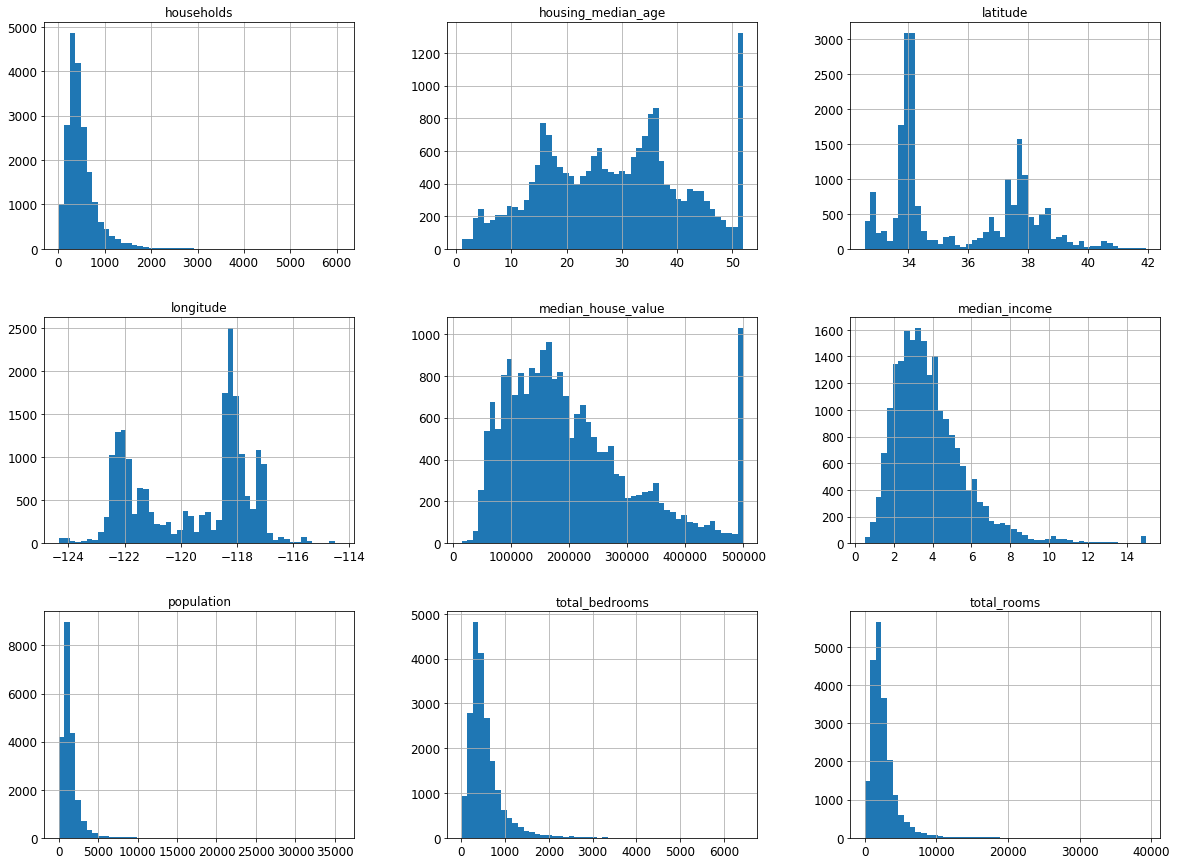

In [9]:
# only in a Jupyter notebook
# 另一种快速了解数据的方法是绘制直方图
%matplotlib inline  
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

**hist（）** 方法依赖于Matplotlib，而Matplotlib依赖于用户指定的图形后端在屏幕上绘制。 所以在你可以绘制任何东西之前，你需要指定Matplotlib应该使用哪个后端。 最简单的选择是使用Jupyter的万能命令**％matplotlib inline**。 这告诉Jupyter设置Matplotlib,所以它使用了Jupyter自己的后端。 然后在笔记本本身内呈现图。 

**请注意**，在Jupyter笔记本中调用**show（）是可选**的，因为Jupyter会在执行单元格时自动显示绘图

请注意这些直方图中的一些内容：

1.首先，收入中位数属性看起来不像以美元表示（USD）。在与收集数据的团队核实后，被告知数据已经缩放并且**上限为15**（实际为15.0001），以获得更高的中位数收入，低收入中位数为0.5（实际为0.4999）。使用预处理属性在机器学习中很常见，并不一定是问题，但您应该尝试了解数据的计算方式。

2.**房屋年龄中位数**和**房屋价格中位数**也受到限制。后者可能是一个严重的问题，因为它是您的目标属性（您的标签）你的机器学习算法可能会发现价格永远不会超过这个限制。您需要与您的客户团队核实，看看这是否是一个问题。如果他们告诉你他们需要精确的预测，甚至超过50万美元的部分也需要，那么你主要有两种选择：

* 为标签上限的区域收集适当的标签。
* 从训练集中删除这些区域（以及从测试集中删除,因为如果预测超出$ 500,000，则不应对您的系统进行评估） 


3.这些属性的尺度差别很大。我们将在本章后面我们**探索特征缩放**时讨论这些。

4.最后，许多直方图都是**尾重**的：它们在**中位数右侧比在左侧延伸得更远**。这可能会使某些机器学习算法难以检测模式。稍后我们将尝试转换这些属性以获得更多钟形分布。

#### 2.2 Create a Test Set-通过采样创建测试集

人的大脑是一个惊人的模式检测系统，这意味着它是极容易过拟合：如果你看一下测试集，你可能会偶然发现测试数据中一些看似有趣的模式，导致你选择一种特定类型的机器学习模型。 当您使用测试集估计泛化错误时，您的估计将过于乐观，并且您将启动一个性能不如预期的系统。 这称为**数据窥探偏差**。
所以我们要创建一个Test Set,把它放在一边再也不要偷看

In [10]:
# to make this notebook's output identical at every run
np.random.seed(42)

下面的代码是有效的，但它并不完美：如果再次运行程序，它将生成一个不同的测试集！ 随着时间的推移，您（或您的机器学习算法）将会查看到整个数据集，这是您想要避免的。

* **一种解决方案**是在第一次运行时保存测试集，然后在后续加载它运行。 

* **另一种**选择是在调用**np.random.permutation（）**之前设置随机数生成器的种子（例如，**np.random.seed（42）**），它总是生成相同的 shuffled indices.。

You will often see people set the random seed to 42. This number has no special property, other than to be The Answer to the Ultimate Question of Life, the Universe, and Everything.

In [11]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
#调用上面定义的函数
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


但是，下次获取更新的数据集时，上面两种解决方案都会中断。 一个常见的解决方案是：
* 使用每个实例的标识符来决定它是否应该进入测试集（假设实例具有唯一且不可变的标识符）。例如，
   
   **i.** 您可以计算每个实例的标识符的哈希值，仅保留哈希值的最后一个字节，如果此值小于或等于51（256的~20％），则将实例放入测试集中。 
   
   **ii.** 这可确保测试集在多次运行中保持一致，即使您刷新数据集也是如此。 
   

新测试集将包含20％的新实例，但它不包含以前在训练集中的任何实例。 这是一个可能的实现：

In [13]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

不幸的是，住房数据集没有标识符列。 最简单的解决方案是使用行索引作为ID：

In [14]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

如果使用行索引作为唯一标识符，则需要确保新数据被附加到数据集的末尾，并且没有行被删除。如果无法做到这一点，那么您可以尝试使用最稳定的特征来构建唯一标识符。例如，区域的纬度和经度保证稳定在至少数百万年，所以你可以将它们组合成一个如此ID：

需要**注意**的是：位置信息实际上非常粗糙，因此许多区域将具有完全相同的ID，因此它们将最终位于同一组（测试或训练集）中。这引入了一些抽样偏差。

In [15]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [16]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


Scikit-Learn提供了很多函数可以将数据集拆分为多个子集。 最简单的函数是**train_test_split**，它与前面定义的**split_train_test**函数几乎完全相同，它有两个额外的参数：

* 首先，有一个**random_state**参数，允许您设置如前所述的随机生成器种子，
* 其次，您可以传递多个具有相同行数的数据集，并将它们分割在相同的索引上（这是非常有用，例如，如果你有一个单独的标签DataFrame）：

In [17]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [18]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


对于预测房屋价格中位数，收入的中位数通常非常重要。您可能希望确保**测试集**代表整个数据集中的各种收入水平的人群。由于收入中位数是连续**数字属性**，因此首先需要创建**收入类别属性**。 让我们更仔细地看一下**收入中位数直方图**

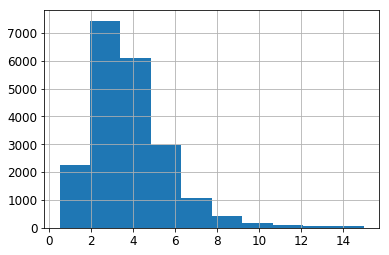

In [19]:
housing["median_income"].hist()

* 大多数收入中位数集中在2-5（万美元）左右，
* 但是一些收入中位数远远超过6.

**每个阶层的数据集中有足够数量的实例非常重要**，或者对阶层重要性的估计可能有偏见。 这意味着你不应该有太多的阶层，每个阶层应该足够大。 

以下代码通过:
* 将**收入中位数除以1.5（以限制收入类别的数量**）
* 并使用**ceil**（具有离散类别）进行四舍五入，然后将收入**大于5万美元**的所有类别合并到5万美元中

来创建**收入类别属性-"income_cat"**：

In [20]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [21]:
# 对收入中位数按照1万美元，2万美元，3万美元，4万美元，5万及5万以上进行统计
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

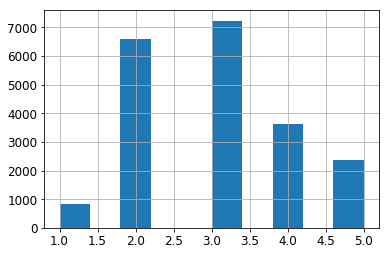

In [22]:
#对收入中位数做直方图
housing["income_cat"].hist()

现在，您已准备好**根据收入类别**进行**分层抽样**。 为此你可以使用Scikit-Learn的**StratifiedShuffleSplit(分层随机拆分)**类：

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

让我们看看这是否按预期工作。您可以在**完整住房数据集**中从查看收入类别比例开始

In [24]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

使用类似的代码，您可以查看**测试集**中的收入类别比例

In [25]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

下面的代码比较了**整个数据集**，使用**分层采样生成的测试集**，以及**使用纯随机抽样生成的测试集（stratified sampling:）**中的**收入类别比例**。 如您所见，使用**分层抽样生成的测试集**的收入类别比例几乎与**完整数据集中**的相同，而使用纯随机抽样生成的测试集非常偏斜。

In [26]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [27]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


**现在您应该删除income_cat属性，以便数据恢复原始状态：**

In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

我们在**测试集生成**上花了相当多的时间是有充分理由的：这是经常被忽视但却是机器学习项目中的关键部分。而且，其中很多在我们讨论**交叉验证**时，这些想法会很有用。 现在是时候继续前进了
到下一个阶段：**探索数据**。

## 3.Discover and Visualize the Data to Gain Insights

到目前为止，我们只是快速浏览了一下数据，大致了解了我们正在操作的数据的类型。 现在的目标是更深入一点。
首先，确保已经把测试放在一边，我们只是在探索训练集。 此外，如果训练集非常大，您可能需要对训练集进行采样，以便轻松快速地进行操作。 在本例中，训练集很小，所以我们可以直接在全部数据上工作。 
* 让我们创建一个**训练集数据副本**，这样我们就可以在不损害训练集的情况下探索它：

In [29]:
housing=strat_train_set.copy()

#### 3.1 Visualizing Geographical Data-可视化地理数据

由于有地理信息（纬度和经度），所以最好创建所有区域的**散点图**以可视化数据（图2-11）：

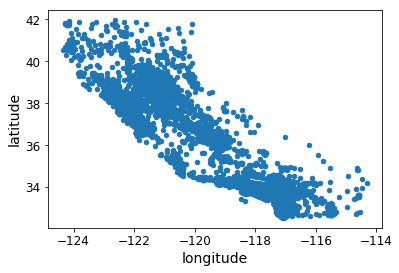

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude")

这看起来像加利福尼亚州，但除此之外很难看到任何特别的东西。 将alpha选项设置为0.1(参数alpha决定图表的填充不透明度，范围[0,1]，默认值是1)可以更容易地显示存在高密度数据点的地方（图2-12）：

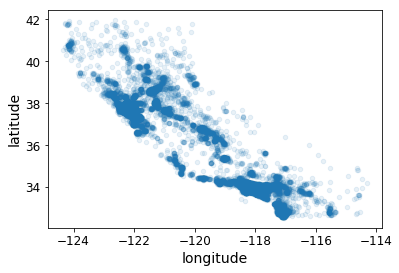

In [31]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

现在情况好多了：你可以清楚地看到高密度区域，即海湾地区以及洛杉矶和圣地亚哥的周围地区，以及 Central Valley中一条相当高密度的长线，特别是Sacramento and Fresno周围。

更一般地说，我们的大脑非常擅长在图片上发现图案，但是你可能需要使用可视化参数来使模式脱颖而出。

现在让我们来看看房价：
* 每个圆的半径代表区的人口（选项s）
* 颜色代表价格（选项c）
* 我们将使用一个名为**jet**的预定义颜色图（选项cmap），范围从蓝色（低）到红色（高）：15

Saving figure housing_prices_scatterplot


FileNotFoundError: [Errno 2] No such file or directory: 'F:\\ML\\Machine learning\\Hands-on machine learning with scikit-learn and tensorflow\\images\\02_End_to_End_project\\housing_prices_scatterplot.png'

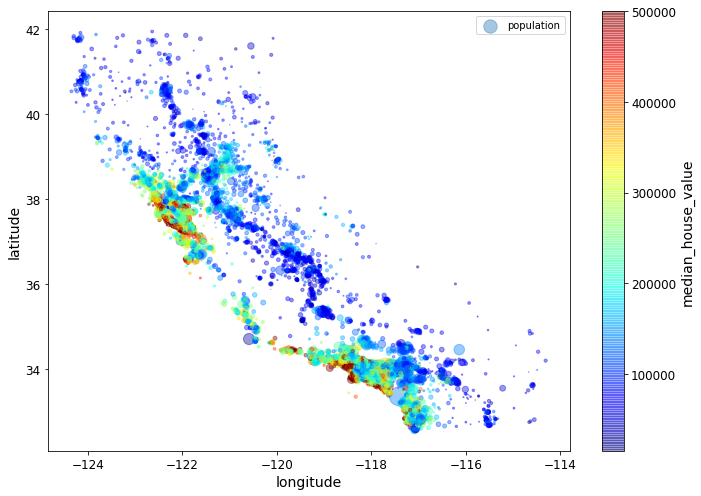

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population",figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), 
             colorbar=True,
             sharex=False)

plt.legend()
save_fig("housing_prices_scatterplot")

从这张图片告诉你：

* 房价与**位置**有很大关系（例如，靠近海洋）和人口密度也有很大关系。因此使用**聚类算法**来检测主要聚类可能是有用的，添加用于衡量群集中心距离的新功能。 

* **海洋邻近属性**也可能有用，尽管在北加利福尼亚州沿海地区的房价不是太高，因此这不是一个简单的规则。

下面的代码将上图放在了加利福尼亚的地图之上，运行之前需要在图片保存路径中提前保存一张加州地图，以便读取

In [ ]:
import matplotlib.image as mpimg

# 读取加州地图
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/02_End_to_End_project/california.png')

# 要在其上进行绘制的matplotlib subplot 对象。如果没有设置，则使用当前matplotlib subplot
# 
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, 
                  alpha=0.4,
                 )

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)

cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

#### 3.2 Looking for Correlations-寻找相关性

由于数据集不是太大，我们可以使用**corr（）**轻松计算每对属性之间的**标准相关性系数（也称为Pearson’s）**：

In [ ]:
corr_matrix = housing.corr()

查看**每个属性与房屋中值的相关程度**：

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

相关系数的范围是[-1,1].
* 当它**接近1**时，就意味着有很强的**正相关**; 例如，当收入**中位数上升**时，**房屋中位数**价值往往会**上升**。 

* 当系数**接近-1**时，意味着有强烈的**负相关**; 你可以在**纬度**和**房价中位数**之间看到一个小的**负相关**（即,当你往北时价格略有**下跌趋势**)。

* 最后，接近零的系数意味着没有线性相关。 下图显示了各种图以及它们的水平轴和垂直轴之间的相关系数。
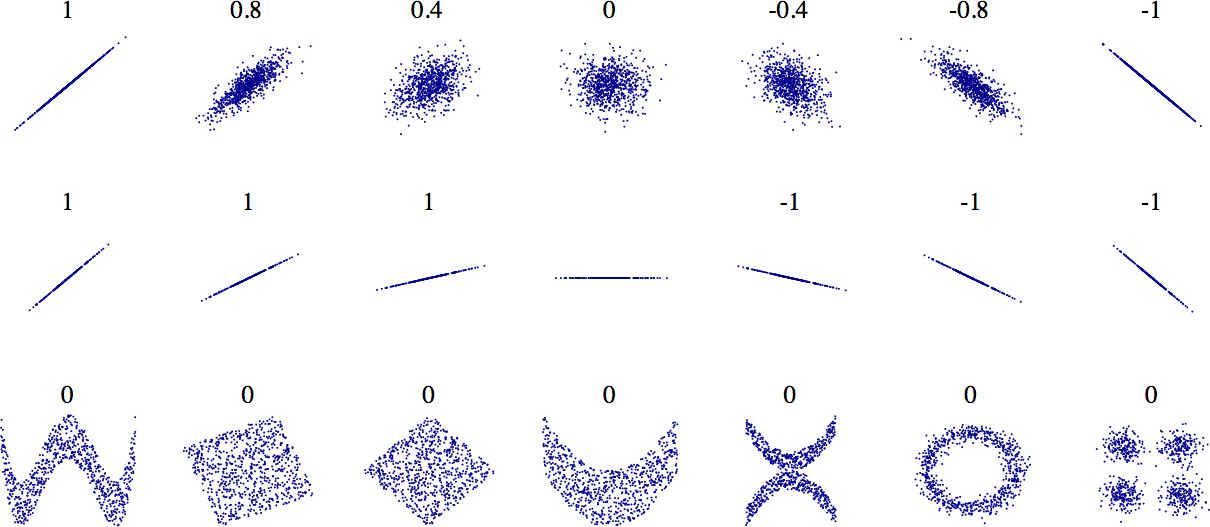

**注意**：

1. 相关系数**仅测量线性相关**（“如果x上升，则y通常上升/下降”）。**它可能完全错过非线性关系**（例如，“如果x接近零，那么y通常会上升”）。
2. 注意底行的所有图都具有**等于零**的相关系数，尽管它们的轴明显不是独立的：这些是**非线性关系**的例子。 
3. 此外，第二行示出了相关系数等于1或-1的示例; 请注意，这与**斜率**无关。例如，你的身高以英寸为单位，与以英尺或纳米为单位的身高相关系数为1。

**检查属性之间相关性**的另一种方法是使用Pandas'**scatter_matrix**函数，它画出每个数字属性与其他数字属性之间的相关性。这里有11个属性，所以共有121个图会被画出来，由于屏幕限制，我们这里只关注一些看似与**房价中位数最相关的有希望的属性**

根据上面运行的结果，与房价中位数相关性较高的前三名是：

* median_income
* total_rooms
* housing_median_age


In [ ]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value",
              "median_income", 
              "total_rooms",
              "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

如果Pandas针对每个变量自身绘制相关性图表，那么主对角线（从左上角到右下角）将充满直线，这不是非常有用。 因此，Pandas会显示每个属性的直方图（其他选项可用;有关详细信息，请参阅Pandas的文档）。

根据上面两种查看相关性的方法得到的结果，**预测房屋中值的最有希望的属性是收入中位数**，所以让我们放大他们的相关性散点图

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

可以看出几点：
* 首先，相关性确实很强; 我们可以清楚地看到上升趋势并且这些点不是太分散。 
* 第二，我们之前注意到的价格上限清晰可见，大概为500,000美元的水平线。
* 但是从这里还可以看出其他不太明显的几条线直线：一条约450,000美元的水平线，另一条约350,000美元的水平线，也许一个约280,000美元，还有一些低于此值。

您可能想尝试删除相应的区域以防止你的算法学习重现这些数据的怪癖。

#### 3.3 Experimenting with Attribute Combinations-尝试使用组合属性
到目前为止，
* 我们已经了解了一些探索数据的方法，并且对数据也有了一定的了解，
* 还对各属性之间的相关性进行了分析，特别是与目标属性之间的相关性。
* 由于一些属性具有尾重型的分布，所以我们可以对他们进行转换（比如对数转换），项目不同，采取的转换方法也不一样。

在将数据送进机器学习算法之前，我们可以想做的最后一件事是尝试各种组合属性，例如，
* 在一个地区，如果你不知道有多少家庭，那么房间总数就不是很有用。你真正想要的是**每个家庭的房间数量**。
* 同样，卧室总数本身并不是很有用：你可能想把它与房间数量进行比较。而且每户人口也是如此


In [ ]:
# 每个家庭平均拥有的房间数 = 总房间数 / 总的家庭数
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

# 总卧室数/总房间数
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

# 平均家庭人口数 = 总人口 / 总家庭数
housing["population_per_household"]=housing["population"]/housing["households"]

In [ ]:
# 查看新的属性的相关性系数
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

In [ ]:
#绘制散点图
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [ ]:
housing.describe()

结果还不算坏：
* 新的bedroom_per_room属性与房屋中位数值的相关性远高于**房间**或**卧室**的总数-显然，**卧室/房间比率较低**的房屋往往更贵。
* **每个家庭的房间数量**也比**一个地区的房间总数**更多信息 - 显然房屋越大，它们就越贵。

这轮探索不一定非常彻底：重点是我们在用正确的方法，快速获得对数据的的见解，这有助于我们获得第一个合理的原型。 不过这是一个迭代过程：一旦您启动并运行原型，您就可以分析其输出以获得更多见解并回到此探索步骤。

## 4. Prepare the Data for Machine Learning Algorithms-准备机器学习算法的数据

是时候为机器学习算法准备数据了。我们应该编写函数来执行此操作，而不仅仅是手动执行此操作，原因如下：
* 这将允许我们轻松地在**任何数据集上重现这些转换**（例如，下次你获得一个新的数据集）。
* 您将逐步构建可以在未来的项目中**重复使用**的转换函数库。
* 您可以在实时系统中使用这些功能来转换新数据，在将新数据提供给您的算法之前。
* 这将使您可以轻松尝试各种转换并查看哪种转换组合效果最好。

首先让我们恢复一个干净的训练集（通过再次调用**strat_train_set**），并且将预测变量和标签分开，因为我们不想把相同的转换应用在预测变量和目标值上（请注意，**drop（）**创建了数据的一个副本并且不影响**strat_train_set**）：

In [ ]:
# 将"median_house_value"一列去掉，同时创建数据副本，作为训练集
housing = strat_train_set.drop("median_house_value", axis=1)

# 创建数据集标签："median_house_value"即为标签
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
strat_train_set.describe()

以下代码**抽样取出部分新创建的训练集中的实例**，查看表头信息，验证"median_house_value"是否被去掉，如果被去掉，每个实例的属性应该只剩下9个，原来是10个

In [ ]:
#  df.any 返回某一列或某一行存在缺失值
df = pd.DataFrame({"A": [0, 2], "B": [0, 2], "C": [0, 0]})
print(df)
print('axis =1 \n')
print((df.any(axis=1)))
print('axis =0 \n')
print((df.any()))

In [ ]:
type  (housing.isnull().any(axis=1))

In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()

sample_incomplete_rows

#### 4.1 Data Cleaning-数据清洗
大多数机器学习算法无法处理**缺失值**，所以需要我们创建一些函数来处理缺失值。 我们在前面注意到**total_bedrooms**这个属性有一些缺失值，所以现在我们来解决这个问题。 你有三个选择：
* 删除相应的区域-Get rid of the corresponding districts.
* 删除整个属性- Get rid of the whole attribute.
* 将缺失值设置为某个值（零，均值，中位数等）-Set the values to some value (zero, the mean, the median, etc.).

您可以使用DataFrame的**dropna（），drop（）和fillna（）**轻松完成这些操作：

**注意：以下三个cell是对三个选择的使用演示，所以均使用上面刚刚抽样取出的新训练集的实例，这样真实的训练集并没有收到影响**

In [ ]:
tmp1= sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1-删除相应的区域-
tmp1

In [ ]:
# 去掉“total_bedrooms”这个属性
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2-删除整个属性

In [ ]:
# 计算中值
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3-将缺失值设置为某个值（零，均值，中位数等）
sample_incomplete_rows

如果选择第三种方法，则应计算**训练集**的中值，并且用它来填充**训练集**中的缺失值，但也不要忘记保存您计算的中值。稍后在您想要评估系统时，您将需要用它来替换**测试集**中的缺失值，以及系统上线后替换**新数据**中的缺失值。

Scikit-Learn提供了一个方便的类来**处理缺失值：Imputer**：
* 首先，您需要创建一个**Imputer**实例，并且**指定您想要用某个属性的中位数替换该属性的缺失值**：

In [ ]:
# from sklearn.preprocessing import Imputer
from sklearn.impute import  SimpleImputer as Imputer
# 创建实例，并且指定用中位数替换缺失值
# "median"即："total_bedrooms"的中值 在上一个cell中已经计算出来了，这里直接用就好了
imputer = Imputer(strategy="median")

In [ ]:
# Remove the text attribute because median can only be calculated on numerical attributes:
# ocean_proximity这一列的内容是文本属性的，而中位数只能在数值类属性上计算，
# 所以我们需要创建一个没有ocean_proximity的数据副本，即把这一列去掉
housing_num = housing.drop('ocean_proximity', axis=1)

# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
# 使用fit（）将imputer实例 fit 到训练数据：
imputer.fit(housing_num)

**imputer**只是简单地计算了每个属性的中位数，并将结果存储在**statistics_ instance**变量中。虽然在本项目中只有"total_bedrooms"属性具有缺失值，但我们无法确定系统上线后新数据中是否会存在任何缺失值，因此为了安全起见将**imputer应用于所有的数值类属性**：

In [ ]:
imputer.statistics_

In [ ]:
housing_num.median().values

In [ ]:
# 检查刚才计算的中值和前面手工计算的中值是否相等
housing_num.median().values

现在可以使用这个“训练有素”的**imputer**通过学习得到的中位数替换缺失值来对训练集进行转换：

In [ ]:
X = imputer.transform(housing_num)


结果是包含转换特征的普通Numpy数组。如果你想把它放回到Pandas DataFrame中，很简单：

**housing_tr = pd.DataFrame(X, columns=housing_num.columns)**

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))
housing_tr.isnull().any()

In [ ]:
type(sample_incomplete_rows.index)

In [ ]:
housing_tr.loc[sample_incomplete_rows.index.values]

In [ ]:
imputer.strategy

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

###### 现在让我们预处理分类输入特征，ocean_proximity：

In [ ]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)
print(type(housing_cat))

#### 4.2  Handling Text and Categorical Attributes-处理文本和分类属性

前面我们单独把"ocean_proximity"这个属性留了出来，因为它是文本类的属性，所以我们不能计算它的中值，大多数机器学习算法更倾向于处理数字类型的数据，所以我们需要把他们转换为数字型

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
encoder = LabelEncoder()
print((type(encoder)))
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded
print(type(housing_cat_encoded))

In [ ]:
print(encoder.classes_)

这种表示的一个问题是ML算法将假定，两个离得近的值比两个离得远的值更相似。 显然情况并非如此（例如，类别0和类别4比类别0和类别1更相似）。 要解决此问题，常见的解决方案是为每个类别创建一个二进制属性：
* 当类别为“<1H OCEAN”时，一个属性等于1（否则为0）
* 当类别为“INLAND”时，另一个属性等于1（ 否则为0，等等。 

这称为**one-hot encoding**,，因为只有一个属性等于1（**hot**），而其他属性将为0（**cold**）。

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

默认情况下，**OneHotEncoder**类返回一个**稀疏数组**，但如果需要，我们可以通过调用**toarray（）**方法将其转换为**密集数组**：

In [ ]:
housing_cat_1hot.toarray()

我们可以使用**LabelBinarizer**类一次性完成这两种转换（从文本类别到整数类别，然后从整数类别到one-hot矢量）：

In [ ]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

#### 4.3 Custom Transformers-定制转换器
让我们创建一个自定义 transformer来添加额外的属性：

虽然Scikit-Learn提供了许多有用的transformers，但我们需要编写我们自己的transformer来执行诸如自定义清理操作或特定组合属性等任务。 我们希望自定义的transformers与Scikit-Learn的功能（例如管道）无缝协作，并且由于Scikit-Learn依赖于duck typing（不是继承），所以你需要的只是创建一个类并实现三个函数：
* fit（）返回self（）
* transform（）
* fit_transform（）

最后一个只需要添加**TransformerMixin**作为基类即可实现。 此外，如果将**BaseEstimator**添加为基类（并避免构造函数中的* args和** kargs），我们可以获得两个额外的方法（get_params（）和set_params（）），这些方法对自动调整超参数很有用。 例如，这是一个小型transformer类，它添加了我们前面讨论过的组合属性：

In [ ]:
tmp2 =housing.values[:3,-1]
tmp3 =housing.values[:3,-2]
print(np.c_[tmp2,tmp3])
# print(housing.values[:,4])

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index-列索引1
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
#       numpy对象
#       每个家庭平均房间数 每个家庭平均人口
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
# attr_adder.add_bedrooms_per_room
housing_extra_attribs = attr_adder.transform(housing.values)

在这个例子中，transformer有一个超参数*add_bedrooms_per_room*，默认情况下设置为True（提供合理的默认值通常很有帮助）。此超参数将允许您轻松找出添加此属性是否有助于机器学习算法。 更一般地说，您可以添加超参数来控制您不是100％确定的任何数据准备步骤。 您自动执行这些数据准备步骤的次数越多，您可以自动尝试的组合越多，您就越有可能找到一个很好的组合（并节省大量时间）。

In [ ]:
# attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
# housing_extra_attribs = attr_adder.transform(housing.values)
# #  通过上面的定制转换器多加一个组合属性，将NUMPY数组再换回原来的DATAFRAME
# housing_extra_attribs = pd.DataFrame(
#     housing_extra_attribs,
#     columns=list(housing.columns)+["rooms_per_household", "population_per_household",'bedrooms_per_room'])
# housing_extra_attribs.head()

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

#### 4.4 Feature Scaling-特征缩放

我们需要应用于数据的最重要的转换之一是**特征缩放**。除了少数例外，当输入数字属性具有非常不同的比例时，机器学习算法表现不佳。住房数据就是这种情况：房间总数在6到39,320之间，而收入中位数的范围只有0到15.请注意，通常不需要缩放**target values**。有两种常用方法可以使所有属性具有相同的比例：**min-max缩放**和**标准化**

* **最小-最大缩放-Min-max scaling**（许多人称之为**normalization**）：移动和重新调整值，使它们范围变成[0,1]。我们通过(X-Xmin)/(Xmax-Xmin)来实现。为此，Scikit-Learn提供了一个名为**MinMaxScaler**的*transformer*。它有一个**feature_range**超参数，如果由于某种原因你不想要[0-1]，它可以让你改变范围。


* **标准化-Standardization**是完全不同的：它首先减去平均值（如此标准化值总是具有零均值），然后它除以方差，以便得到的分布具有单位方差。与最小-最大缩放不同，标准化不将值缩放到特定范围，这对于某些算法可能是一个问题（例如，神经网络通常期望输入值范围是从0到1）。但是，标准化受异常值的影响要小得多。例如，假设一个地区的收入中位数等于100（错误地）。然后，最小-最大缩放将所有其他值从0-15压缩到0-0.15，而标准化不会受到太大影响。 Scikit-Learn提供了一个名为**StandardScaler**的*transformer*用于标准化。

**注意：特征缩放只在训练集上进行**

#### Transformation Pipelines
如您所见，有许多数据转换步骤需要按正确的顺序执行。不过Scikit-Learn提供了**Pipeline**类来帮助完成这些转换序列。 这是一个用于数值属性的小型Pipeline：

In [ ]:
print(type(housing_num))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
#pipeline fit 再transform做法
housing_num_tr_fit = num_pipeline.fit(housing_num)
housing_num_tr_fit.transform(housing_num)

In [ ]:
housing_num_tr

Pipeline构造函数采用: **('名称',estimator)** 这样的列表形式来定义一系列步骤。 除最后一个estimator之外的所有estimator都必须是transformers（即，它们必须具有**fit_transform（）**方法）。 名字可以是你喜欢的任何名字。

当你调用Pipeline的**fit（）方法**时，它在所有transformer上顺序调用**fit_transform（）**，将每个调用的输出作为参数传递给下一个调用，直到它到达最后一个estimator，在最后一个这里它只是调用**fit（）方法**。

Pipeline显示了它与最终estimator相同的方法。 在这个例子中，最后一个estimator是一个**StandardScaler**，它是一个transformer，所以Pipeline有一个**transform（）方法**，它按顺序将所有变换应用于数据（它还有一个**fit_transform**方法，我们可以使用它而不是先调用**fit（）**然后调用**transform()**）

In [ ]:
from sklearn.compose import ColumnTransformer
# list(housing_num)

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
print(housing_prepared.shape)
print(housing.shape)
housing_prepared = pd.DataFrame(
    housing_prepared)
housing_prepared.head()

In [ ]:
housing_prepared.shape

* 以上是基于Scikit-Learn 0.20做出的结果，早期版本使用基于DataFrameSelector转换器和FeatureUnion的解决方案将不同的转换应用于不同的列。作为参考，下面是基于DataFrameSelector transformer （仅选择Pandas DataFrame列的子集）和FeatureUnion的旧版解决方案：

我们现在有一个数值Pipeline，您还需要在分类值上应用**LabelBi narizer**：如何将这些转换连接到单个pipeline？ 

Scikit-Learn为此提供了一个**FeatureUnion类**:

1. 你给它一个transformers列表（可以是整个transformer pipelines），
2. 当它的transform（）方法被调用时，它并行运行每个transformer的**transform()** 方法，
3. 等待它们的输出，然后连接它们并返回结果（当然，调用**fit（）方法**会调用所有transformer的**fit（）方法**）。 

处理数字和分类属性的完整Pipeline可能如下所示：

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

#Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values


In [ ]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)# 数字属性
cat_attribs = ["ocean_proximity"]# 分类属性

# 定义数字属性的 Pipeline
old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# 定义分类属性的Pipeline
old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])


old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [ ]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

In [ ]:
old_num_pipeline.fit_transform(housing)

In [ ]:
np.allclose(housing_prepared, old_housing_prepared)

### 5. Select and Train a Model-选择模型并进行训练
到目前位置，我们已经将问题建立起来，得到了数据并对其进行了探索，得到了一个训练集和测试集，编写了**transformation pipelines**来清理数据并自动为机器学习算法准备数据。 现在我们准备好选择和训练机器学习模型了。

#### 5.1 Training and Evaluating on the Training Set-训练集的训练与评估
好消息是，由于所有这些先前的步骤，现在情况将会比你想象的要简单得多。 让我们首先训练一个**线性回归模型**，比如我们在第一章做过的：

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

我们现在有一个有效的线性回归模型。 让我们在训练集的几个实例中试一试：

In [ ]:
housing.iloc[:5]

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

与实际值比较：

In [ ]:
 print("Labels:\t\t", list(some_labels))

In [ ]:
some_data_prepared

虽然预测不准确，但它确实有效（例如，第二个预测值，偏差超过50％！）。 让我们使用Scikit-Learn的**mean_squared_error**函数在**整个训练集上**测量这个回归模型的**RMSE**：

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
(lin_rmse)

有总比没有好，但这显然不是一个好成绩：大多数地区'median_housing_values'介于$ 120,000和$ 265,000之间，所以68,628美元的典型预测误差并不令人满意。这是一个模型在**训练数据**上**欠拟合**的例子。它可能意味着：
* 特征不能提供足够的信息来做出良好的预测，
* 或者模型不够强大。

正如我们在前一章中所看到的，修复欠拟合的主要方法是：
* 选择一个更强大的模型，
* 为训练算法提供更好的特征，
* 或者减少对模型的约束。

此模型未正则化，因此排除了最后一个选项。我们可以尝试添加更多的特征（例如，the log of the population），但首先让我们尝试一个更复杂的模型，看看它是如何做的。

让我们训练一个**DecisionTreeRegressor**。这是一个功能强大的模型，能够在数据中找到复杂的非线性关系（决策树在第6章中有更详细的介绍）。现在代码应该看起来很熟悉了：

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

现在模型已经过训练，让我们在**训练集**上进行评估：

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

没有错误？ 这个模型真的可以如此完美吗？当然，模型更可能**过拟合**数据。 如何确定呢？正如我们之前看到的那样，在准备启动之前，您不希望触摸**测试集**，直到你准备推出一个你有信心的模型，因此，您需要使用**训练集**的一部分进行训练，一部分进行模型验证。

#### 5.2 Better Evaluation Using Cross-Validation-使用交叉验证进行更好的评估
评估决策树模型的一种方法是使用**train_test_split函数**将训练集拆分为较小的**训练集**和**验证集**，然后针对较小的**训练集**训练模型并根据**验证集**对其进行评估。 这是一项工作，但没有什么太困难，它会运作得相当好。

一个很好的选择是使用Scikit-Learn的**交叉验证**功能。 以下代码执行**K-fold**交叉验证：它将训练集随机分成10个不同的子集称为**folds**，然后它训练和评估决策树模型10次，每次选择不同的**fold**进行评估，在另外9个**folds**上进行训练。结果是一个包含10个评估分数的数组：

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
# 显示结果
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

决策树的结果看起来不像以前那么好。 事实上，它似乎是比线性回归模型更差！请注意，交叉验证不仅可以获得模型性能的估计值，还可以衡量此估算值的精确程度（即其标准偏差）。决策树的得分约为70666，标准偏差为±2928。 如果您只使用了一个验证集，则不会有此信息。 但交叉验证的代价是多次训练模型，因此并非总是可行。
我们可以为线性回归模型计算相同的分数，以进行确认：

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

这个结果显示决策树模型严重**过拟合**了，比线性回归模型表现更差。

让我们现在尝试最后一个模型：**RandomForestRegressor**。 我们在第7章将会详细讲解此模型，随机森林通过在特征的随机子集上训练许多决策树来工作，然后对其预测进行平均。 在许多其他模型之上构建模型称为**Ensemble Learning**，它通常是进一步推动ML算法的好方法。 我们将跳过大部分代码，因为它与其他模型基本相同：

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

forest_rmse

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

这次的结果要好得多：随机森林看起来非常有前途。 但请注意，训练集上的得分仍然远低于验证集，这意味着该模型仍然**过拟合**训练集。 过拟合的可能解决方案是：
* 简化模型，
* 约束模型（即，使其正规化），
* 或获得更多的训练数据。

**然而**，在你深入了解随机森林之前，你应该尝试很多来自各种机器学习算法的其他模型（比如可能是具有不同内核的支持向量机，神经网络等），而不需要花太多时间调整超参数。 目标是将一些（两到五个）有希望的模型列入候选名单。

In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

In [ ]:
# 支持向量机
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

### 6. Fine-Tune Your Model-微调你的模型
让我们假设您现在有一个有前途的模型的候选名单。 你现在需要微调它们。 让我们看看你能做到的几种方法。

#### 6.1 Grid Search-网格搜索
一种方法是手动调整超参数，直到你找到超参数值的完美组合。 这将是一项非常繁琐的工作，你可能没有时间去探索很多组合。

相反，你应该让Scikit-Learn的**GridSearchCV**来帮助你搜索。 您需要做的就是告诉它你想要试验哪些超参数，以及要尝试的值，它将使用交叉验证评估超参数值的所有可能组合。例如，以下代码搜索RandomForestRegressor超参数值的最佳组合：

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [ 3,10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, 
                           param_grid, 
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

当您不知道超参数应该具有什么值时，一种简单的方法是尝试**10的连续幂**（如果您想要更精细的搜索，则尝试更小的数字，如本例中使用n_estimators超参数所示

这个**param_grid**告诉Scikit-Learn
* 首先评估第一个dict中指定的*n_estimators*和*max_features*超参数值的所有3×4= 12个组合（现在不要担心这些超参数意味着什么;在第7章中我们会解释他们）
* 然后在第二个dict中尝试所有2×3 = 6个超参数值组合，但这次将*bootstrap*超参数设置为False而不是True（这是该超参数的默认值）。

总而言之，
* 网格搜索将探索RandomForestRegressor超参数值的18种组合，
* 并将对每个模型进行五次训练（因为我们使用five-fold交叉验证）。

换句话说，总共会有18×5 = 90轮的训练！ 这可能需要相当长的时间，但完成后你可以获得最佳的参数组合，如下所示：

In [ ]:
grid_search.best_params_

由于30是评估的n_estimators的最大值，因此您应该评估更高的值，因为分数可能会继续提高。

You can also get the best estimator directly:

In [ ]:
grid_search.best_estimator_

让我们看看在网格搜索期间测试的每个超参数组合的得分：

In [ ]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

在此示例中，我们通过设置max_features超参数为6，n_estimators超参数为30获得最佳解决方案。 此组合的RMSE得分为49,959，略高于您之前使用默认超参数值（即52583.72407377466）得到的得分。 恭喜，您已经成功调整了最佳模型！

不要忘记，您可以**将一些数据准备步骤视为超参数**。 例如，网格搜索将自动确定是否添加您不确定的功能（例如，使用CombinedAttributesAdder transformeradd_bedrooms_per_room超参数）。 它可以类似地用于自动找到处理异常值，缺失特征，特征选择等的最佳方法。

In [ ]:
pd.DataFrame(grid_search.cv_results_)

#### 6.2 Randomized Search-随机搜索
随机搜索
就像在前面的例子中一样，当您探索相对较少的组合时，网格搜索方法很好，但是当超参数搜索空间很大时，通常最好使用RandomizedSearchCV。这个方法可以与GridSearchCV大致相同的方式使用，但不是尝试所有可能的组合，而是通过在每次迭代中为每个超参数选择随机值来评估给定数量的随机组合。 这种方法有两个主要好处：
* 如果让随机搜索运行，例如1000次迭代，这种方法将会为每个超参数探索1,000个不同的值（而不是网格搜索方法中那样每个超参数的几个值）。
* 您可以更好地控制您想要分配到超参数搜索的计算预算，只需设置迭代次数即可。

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
rnd_search.best_params_

#### 6.3 Ensemble Methods-组合模型
微调模型的另一种方法是尝试表现最好的模型组合。 组（或“组合”）通常比最佳单个模型表现更好（就像随机森林比他们依赖的单个决策树表现更好），特别是如果各个模型产生非常不同类型的错误。我们将在第7章中更详细地介绍这个主题。

### 7. Analyze the Best Models and Their Errors-分析最佳模型及其错误
通过检查最佳模型，您将经常获得关于该问题的良好见解。 例如，RandomForestRegressor可以指示每个属性的相对重要性，以进行准确的预测

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

在相应的属性名称旁边显示这些重要性分数：

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

有了这些信息，您可能想尝试删除一些不太有用的特征（例如，显然只有一个ocean_proximity类别真的很有用，所以你可以试试放弃其他特征）。

你还应该查看模型产生的具体错误，然后尝试说明错误原因和可以解决问题的方法（增加额外的特征，或者相反，摆脱没有信息的，清理异常值等）。

#### 7.1 Evaluate Your System on the Test Set-在测试集上测试模型
在调整模型一段时间后，您最终会拥有一个足够好的可以执行的模型。 现在是时候在测试集上测试最终模型了。这个过程没有什么特别之处; 只需从测试集中获取预测变量和标签，运行**full_pipeline**来转换数据（调用**transform（）**，而不是fit_transform（）！，并评估测试集上的最终模型：

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

如果您进行了大量的超参数调整，那么这个表现通常会比您使用交叉验证进行测量略差一些（因为您的系统最终经过微调以便在验证数据上表现良好，并且可能在未知数据集上的表现不佳）， 在这个例子中并非如此，但是当发生这种情况时，你必须抵制调整超参数的诱惑，以使数字在测试集上看起来很好; 这些改进不太可能推广到新数据

### 8. Launch, Monitor, and Maintain Your System

In [ ]:
# We can compute a 95% confidence interval for the test RMSE:
# 我们可以计算测试RMSE的95％置信区间：
from scipy import stats

In [ ]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

In [ ]:
# We could compute the interval manually like this:
# 我们可以手动计算间隔，如下所示：
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

Alternatively, we could use a z-scores rather than t-scores:
    
或者，我们可以使用z分数而不是t分数：

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

#### Extra material

######  A full pipeline with both preparation and prediction-完整的管道，包括准备和预测

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

###### Model persistence using joblib

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

##### Example SciPy distributions for RandomizedSearchCV-RandomizedSearchCV的示例SciPy分布

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

### Exercise solutions

### 1.
Question: Try a Support Vector Machine regressor (**sklearn.svm.SVR**), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, 
                           param_grid, cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=2, 
                           n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

NameError: name 'housing_prepared' is not defined

The best model achieves the following score (evaluated using 5-fold cross validation):

In [33]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

NameError: name 'grid_search' is not defined

That's much worse than the RandomForestRegressor. Let's check the best hyperparameters found:

In [ ]:
grid_search.best_params_

The linear kernel seems better than the RBF kernel. Notice that the value of C is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for C (removing the smallest values), because it is likely that higher values of C will be better.

### 2.
Question: Try replacing GridSearchCV with RandomizedSearchCV.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

Now this is much closer to the performance of the RandomForestRegressor (but not quite there yet). Let's check the best hyperparameters found:

In [ ]:
rnd_search.best_params_

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the **exponential distribution（指数分布）** we used, with scale=1.0. Note that some samples are much larger or smaller than 1.0, but when you look at the **log of the distribution（对数分布）**, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for C looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()


The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

### 3.
Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a RandomForestRegressor). You may be tempted to compute them directly in the TopFeatureSelector's fit() method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [ ]:
k = 5

Now let's look for the indices of the top k features:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

In [ ]:
np.array(attributes)[top_k_feature_indices]

Let's double check that these are indeed the top k features:

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [ ]:
housing_prepared_top_k_features[0:3]

Now let's double check that these are indeed the top k features:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

### 4.
Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Let's try the full pipeline on a few instances:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best RandomForestRegressor that we found earlier, rather than the best SVR.

### 5.
Question: Automatically explore some preparation options using GridSearchCV.

In [ ]:
param_grid = [
        {'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': list(range(1, len(feature_importances) + 1))}
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

In [ ]:
grid_search_prep.best_params_

In [ ]:
print('hhahahhahhahahahhahahhahldjflsjfljslfjojljneldfhowjrlwnrl')
print('心存善念尽力而为')

The best imputer strategy is most_frequent and apparently almost all features are useful (15 out of 16). The last one (ISLAND) seems to just add some noise.

Congratulations! You already know quite a lot about Machine Learning. :)